# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np
import random

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq

from matplotlib import pyplot as plt
import sklearn.cluster
import tensorflow as tf 
from sklearn.cluster import MiniBatchKMeans

In [ ]:
random.seed(100)
np.random.seed(100) 
tf.random.set_seed(100)

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [ ]:
# modify the dataset variable with the path from your drive

dataset_path = r'drive/MyDrive/P8_images'

In [ ]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [ ]:
# solution
file_dirs = os.listdir(dataset_path)
imgs = [] 
labels = [] 
img_paths = []
data = []

In [ ]:
# for dir in file_dirs:
#   print(dir)

In [ ]:
file_dirs = os.listdir(dataset_path)
imgs = [] 
labels = [] 
img_paths = []
data = []

for dir in file_dirs:
  dir_path = os.path.join(dataset_path, dir)
  file_paths = os.listdir(dir_path)
  for path in file_paths:
    img_path = os.path.join(dir_path, path)
    img_paths.append(img_path)
    img = imread(img_path)
    imgs.append(img) 
    labels.append(dir)
    data.append((img,dir))

In [ ]:
for dir in file_dirs:
  print(labels.count(dir))

91
86
67


In [ ]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [ ]:
# solution
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.1)



In [ ]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


kangaroo
['butterfly' 'dalmatian' 'kangaroo']


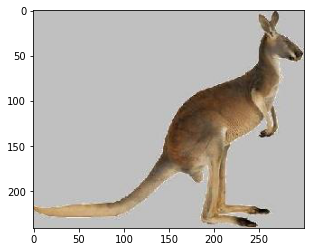

In [ ]:
plt.imshow(x_test[16])
print(y_test[16])
print(np.unique(y_test))

*   How do you select the train/test split?

**Solution**   
We believe there a easy answer for how to choose a ratio for train and test split. So in the previous era of machine learning, it was common practice to take all your data and split it according to maybe a 70/30% in terms of a people often talk about the 70/30 train test splits.   
If you don't have an explicit dev set or maybe a 60/20/20% split in terms of 60% train, 20% dev and 20% test. And several years ago this was widely considered best practice in machine learning. If you have maybe 100 examples in total, maybe 1000 examples in total, maybe after 10,000 examples.     
These sorts of ratios were perfectly reasonable rules of thumb. But in the modern big data era, where, for example, you might have a million examples in total, then the trend is that your dev and test sets have been becoming a much smaller percentage of the total. Because remember, the goal of the dev set or the development set is that you're going to test different algorithms on it and see which algorithm works better. So the dev set just needs to be big enough for you to evaluate, say, two different algorithm choices or ten different algorithm choices and quickly decide which one is doing better. And you might not need a whole 20% of your data for that. If you need just 10,000 for your dev and 10,000 for your test, your ratio will be more like this 10,000 is 1% of 1 million so you'll have 98% train, 1% dev, 1% test.
 And We've also seen applications where, if you have even more than a million examples, you might end up with 99.5% train and 0.25% dev, 0.25% test. Or maybe a 0.4% dev, 0.1% test. 

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [ ]:
# solution
descriptor_extractor = ORB(n_keypoints=256)

*   Extract ORB descriptors from all the images in the train set.


In [ ]:
# solution

def desc_ORB(data):
  descriptors =  []
  keypoints_lst = []
  for img_arr in data:
    img_arr = rgb2gray(img_arr)
    descriptor_extractor.detect_and_extract(img_arr)
    descripts = descriptor_extractor.descriptors
    descriptors.append(descripts)
  return descriptors


descrip_lst = desc_ORB(x_train)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


In [ ]:
to_delete_indeces = [i for i, v in enumerate(descrip_lst) if v.shape[0] != 256]

for ind in to_delete_indeces:
    del descrip_lst[ind]
    del x_train[ind]
    del y_train[ind]

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [ ]:
# solution
descrip_lst[0].shape
#len(descrip_lst)

(256, 256)

In [ ]:
[i for i, v in enumerate(descrip_lst) if v.shape[0] != 256]


[]

**Solution**   
ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. **First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them** by using **non-maximum suppression** to discard keypionts. Here we set the number of keypionts to 256, which is the first dimension we see in the above cell.   
**The second dimension comes from BRIEF descriptor**. Brief takes all keypoints found by the fast algorithm and convert it into a binary feature vector so that together they can represent an object. Binary features vector also know as binary feature descriptor is a feature vector that only contains 1 and 0. In brief, each keypoint is described by a feature vector which is 128–512 bits string. Here the second dimension stands for the default number of features, which is 256 in features.ORB implementation.  

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [ ]:
# solution
ncl = len(categories) * 10
kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=4321)

In [ ]:
# solution
aligned_descriptors = np.concatenate(descrip_lst)
print(aligned_descriptors.shape)
kmeans = kmeans.fit(aligned_descriptors)

(55808, 256)


*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [ ]:
cluster_result = kmeans.predict(aligned_descriptors[:,:])
cluster_result

array([13, 28, 10, ...,  4,  3, 14], dtype=int32)

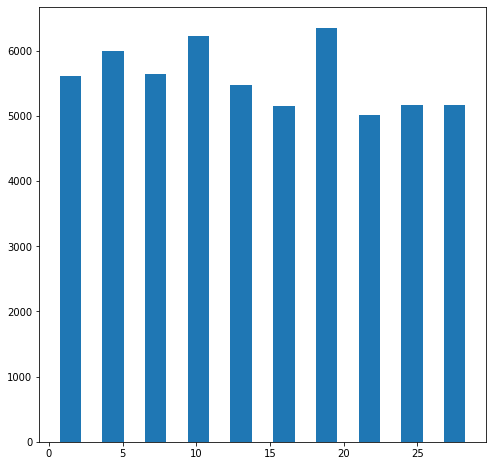

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(cluster_result, rwidth=0.5);

In [ ]:

centroid_vectors = [kmeans.predict(img_descs) for img_descs in descrip_lst]

hist_train = np.zeros((len(centroid_vectors), ncl), "float64")

#for i, sample in enumerate(centroid_vectors):
#    hist_train[i, :] = np.array([list(sample).count(i) for i in range(ncl)])

for i, sample in enumerate(centroid_vectors):
  hist_train[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]

In [ ]:
#plt.hist(hist_train, rwidth=0.5);


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [ ]:
svc = SVC(kernel='rbf')

parameters = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}
clf = GridSearchCV(svc, parameters)

In [ ]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(hist_train)
X_train=stdslr.transform(hist_train)

In [ ]:
clf.fit(X_train, y_train)

svc = clf.best_estimator_


svc
#classi = svm.fit(im_features, y_train)

SVC(C=5.080218046913018, gamma=0.058170913293743576)

In [ ]:
svc.score(X_train, y_train)

1.0

In [ ]:
best_score = clf.best_score_
best_score

0.7339323467230444

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
# solution

test_desc = desc_ORB(x_test)

to_delete_indeces = [i for i, v in enumerate(test_desc) if v.shape[0] != 256]

for ind in to_delete_indeces:
    del test_desc[ind]
    del x_test[ind]
    del y_test[ind]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


In [ ]:
centroid_vectors_test = [kmeans.predict(img_descs) for img_descs in test_desc]


hist_test = np.zeros((len(centroid_vectors_test), ncl), "float64")


#for i, sample in enumerate(centroid_vectors_test):
#    hist_test[i, :] = np.array([list(sample).count(i) for i in range(ncl)])

for i, sample in enumerate(centroid_vectors_test):
  hist_test[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]


In [ ]:
stdslr=StandardScaler().fit(hist_test)
X_test=stdslr.transform(hist_test)


preds = svc.predict(X_test)

*   Calculate the accuracy score for the classification model

In [ ]:
# solution
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.56

*   Generate the confusion matrix for the classification model

In [ ]:
# solution
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds)



array([[3, 1, 3],
       [1, 6, 0],
       [4, 2, 5]])

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**    
 We use Clustering method to group feature vectors generated OBR feature extraction step above to get vector representation of similar patches of images which are known as codeword.  This codeword also produces a codebook is similar to a word dictionary. Since we don't have any labels for similar patches rather than vector representations, we would like to apply unsupervised learning approach such as Kmeans to find similar clusters. 

**Solution**   
Typically, we believe that lots of unsupervised clustering techniques can be applied for grouping vectors in our case, which may include the following categories:
* Based on connectivity: Hierarchical clustering, Fuzzy c means
* Based on centroids: K-means
* Distribution-based models: Mixture models, Expectation-Maximization
* Density models: DBScan, Optics
* Subspace models: Biclustering
* Group models 
* Graph-based models
These above algorithms looks promising to deal with our problem here, and even further, we may try to implement dimension reduction techniques like PCA, ICA or even an new powerful technique called UMAP to improve the performance of clustering. 

*    Will adding more keypoints increase the performanc of the algorithm?

**Solution**      
Should we add more keypoints, we play some trial below, just simply double the size of key points, but the performance dropped from 0.68 to 0.76. So we guess the size of key points does help even not too much for the classification task. For ORB descriptor we implement fast corner detection to get the key points, the we apply the non-maximum suppression method to filter out the false positive ones. So, if we increase the size of key points we actually get more data points in our samples to train and test, which could oboviously boost the potential of our model to reach a higher accuracy. But we are not fully sure about this conclusion, cause we can't try all possible nunmbers. In conclusion, we think it is most likely to get higher performance. 

In [ ]:
# solution
descriptor_extractor_large = ORB(n_keypoints=512)
ncl = len(categories) * 10

def desc_ORB_large(data):
  descriptors =  []
  keypoints_lst = []
  for img_arr in data: 
    img_arr = rgb2gray(img_arr)
    descriptor_extractor_large.detect_and_extract(img_arr)
    descripts = descriptor_extractor_large.descriptors
    descriptors.append(descripts)
  return descriptors

descrip_lst_large = desc_ORB_large(x_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


In [ ]:
kmeans_large = MiniBatchKMeans(n_clusters=ncl)

aligned_descriptors_large = np.concatenate(descrip_lst_large)
kmeans_large_fit = kmeans_large.fit(aligned_descriptors_large)


centroid_vectors_large = [kmeans_large_fit.predict(img_descs) for img_descs in descrip_lst_large]

hist_train_large = np.zeros((len(centroid_vectors_large), ncl), np.float64)
for i, sample in enumerate(centroid_vectors_large):
    hist_train_large[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]


In [ ]:
svc_large = SVC(kernel='rbf')
parameters_large = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}
clf_large = GridSearchCV(svc_large, parameters_large) 

stdslr_large=StandardScaler().fit(hist_train_large)
X_train_large=stdslr_large.transform(hist_train_large)

clf_large.fit(X_train_large, y_train)
svc_large_fit = clf_large.best_estimator_
svc_large_fit

SVC(C=0.7626985859023444, gamma=0.02955209235202888)

In [ ]:
test_desc_large = desc_ORB_large(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


In [ ]:
centroid_vectors_test_large = [kmeans_large_fit.predict(img_descs) for img_descs in test_desc_large]
hist_test_large = np.zeros((len(centroid_vectors_test_large), ncl), "float64")
for i, sample in enumerate(centroid_vectors_test_large):
  hist_test_large[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]

stdslr_test_large =StandardScaler().fit(hist_test_large)
X_test_large=stdslr_test_large.transform(hist_test_large)
preds_large = svc_large_fit.predict(X_test_large)

In [ ]:
large_acc = accuracy_score(y_test, preds_large)
large_acc

0.76

In [ ]:
confusion_matrix(y_test, preds_large)

array([[4, 0, 3],
       [0, 6, 1],
       [1, 1, 9]])

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [ ]:
from tensorflow import keras 
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers 
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from skimage.color import gray2rgb

import cv2

In [ ]:
imagenet_shape = (224, 224, 3) 

In [ ]:
# solution
model_res = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),include_top=True, weights='imagenet') 
model_res.summary()

In [ ]:
from skimage.transform import resize


prueba2 = cv2.resize(x_train[0],(224,224)) #resize(x_train[0], (224, 224), anti_aliasing=True)
print(prueba2.shape)

prueba2 = prueba2.reshape(1,224,224,3)

(224, 224, 3)


In [ ]:
extractor = Model(model_res.inputs, model_res.layers[-2].output) # la menos dos es la avg_pool
avg_pool_features = extractor.predict(prueba2)

In [ ]:
all_features_train = []

for i, img in enumerate(x_train):

  img = cv2.resize(x_train[i],(224,224))
  img = gray2rgb(img)
  img = img.reshape(1,224,224,3)
  all_features_train.append(extractor.predict(img))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  


In [ ]:
all_features_train = np.array(all_features_train).squeeze()

In [ ]:
all_features_train.shape

(218, 2048)

*   What is the size of the feature descriptors?

In [ ]:
# solution

# The shape would be (1, 2048) but we delete one of the shapes when we use squeeze
all_features_train[0].shape


(2048,)

*   Create codebook using the extracted features

In [ ]:
# solution
ncl = len(categories) * 10
kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=1234)

#aligned_features = np.concatenate(all_features)

#print(aligned_features.shape)
kmeans = kmeans.fit(all_features_train)





In [ ]:
centroid_vectors_train_nn = kmeans.predict(all_features_train)

In [ ]:
hist_train_nn = np.zeros((len(centroid_vectors_train_nn), ncl), "float64")

for i, sample in enumerate(centroid_vectors_train_nn):
  hist_train_nn[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]

In [ ]:
# Solo tenemos un vector por imagen, no tiene sentido utilizar histogramas


all_test_features_nn = []

for i, img in enumerate(x_test):

  img = cv2.resize(x_test[i],(224,224))
  img = gray2rgb(img)
  img = img.reshape(1,224,224,3)
  all_test_features_nn.append(extractor.predict(img))




all_test_features_nn = np.array(all_test_features_nn).squeeze()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  if __name__ == '__main__':


In [ ]:

# Esto se hace asi en vez de con un for por el squeeze()
centroid_vectors_test_nn = kmeans.predict(all_test_features_nn)



In [ ]:

hist_test_nn = np.zeros((len(centroid_vectors_test_nn), ncl), "float64")


for i, sample in enumerate(centroid_vectors_test_nn):
  hist_test_nn[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]

*   Train SVM classifier using the codebook

In [ ]:
# solution

svc = SVC(kernel='rbf')

parameters = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}
clf = GridSearchCV(svc, parameters)

from sklearn.preprocessing import StandardScaler

stdslr=StandardScaler().fit(hist_train_nn)
X_train=stdslr.transform(hist_train_nn)


clf.fit(X_train, y_train)

svc = clf.best_estimator_


svc


SVC(C=0.7626985859023444, gamma=0.058170913293743576)

*   Evaluate the test set using the above method

In [ ]:
# solution
stdslr=StandardScaler().fit(hist_test_nn)
X_test=stdslr.transform(hist_test_nn)


preds = svc.predict(X_test)


*   Calculate the accuracy score and confusion matrix for the classification model

In [ ]:
# solution

from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.96

*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**    
Even we have expected that neural network will extract more efficient features than ORB. It is still a little superising to see that we could got an accuracy close 100% both for training and testing. Since the effiectiveness of ResNet together with weights from Imagenet as Backbone Network has been proven by so many cases and even lots of application in real world. It should have no trouble on classification on such an small image dataset. T wonderful performance partially comes from the weapon of deep learning, and could also depend on the Imagenet dataset. The full ImageNet dataset was developed for the ImageNet Large Scale Visual Recognition Challenge (ILSVRC). More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet is organized organized according to the WordNet hierarchy, containing more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images. Features extracted on suhc an enormous dataset will definitely provides more semantic meaning of a whole image.

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**    
We believe that performance of pre-train model could reach 100% if we do follow the  whole all the framework of ResNet50 rather than implementing the codebook method. But we need to modify the last layer of 1000 neuroans into layer of 3 neurons, and fine-tune the weights on the last two fully connected layers on our customized dataset.



*   What happens if the test image does not belong to any of the trained classes?

**Solution**   
We believe both for ORB method and pre-train model the testing performance will drop dramastically after the mismatch existing between training and testing data. Because we can not build the dictionary for all vocabularies for our classification tasks. That means we can not project our test cases into the correct categories. So we can not get meaningful classification result. 

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution

features_train_orb = np.array(descrip_lst)
features_train_nn = np.array(all_features_train)



features_test_orb = np.array(test_desc)
features_test_nn = np.array(all_test_features_nn)


In [ ]:
features_train_nn.shape

(218, 2048)

In [ ]:
features_train_nn_trans = []
for vec in features_train_nn:
  features_train_nn_trans.append(np.array(vec).reshape(8,256))




In [ ]:
tot_train_features = []
for i, vec in enumerate(features_train_orb):
      #print(np.array(vec).shape)
      #print(features_train_nn_trans[i].shape)
      #print(np.append(np.array(vec), features_train_nn_trans[i], axis=0).shape)
      tot_train_features.append(np.append(np.array(vec), features_train_nn_trans[i], axis=0))




In [ ]:
tot_train_features = np.array(tot_train_features)


tot_train_features.shape

(218, 264, 256)

In [ ]:
ncl = len(categories) * 10
kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=4321)

# solution
tot_aligned_descriptors = np.concatenate(tot_train_features)
print(tot_aligned_descriptors.shape)
kmeans = kmeans.fit(tot_aligned_descriptors)



centroid_vectors_tot = [kmeans.predict(img_descs) for img_descs in tot_train_features]


hist_train_tot = np.zeros((len(centroid_vectors_tot), ncl), "float64")

#for i, sample in enumerate(centroid_vectors):
#    hist_train[i, :] = np.array([list(sample).count(i) for i in range(ncl)])




for i, sample in enumerate(centroid_vectors_tot):
  hist_train_tot[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]




(57552, 256)


In [ ]:
features_test_nn_trans = []
for vec in features_test_nn:
  features_test_nn_trans.append(np.array(vec).reshape(8,256))

tot_test_features = []
for i, vec in enumerate(features_test_orb):

      tot_test_features.append(np.append(np.array(vec), features_test_nn_trans[i], axis=0))



In [ ]:
tot_test_features = np.array(tot_test_features)


tot_test_features.shape

(25, 264, 256)

In [ ]:




centroid_vectors_tot_test = [kmeans.predict(img_descs) for img_descs in tot_test_features]


hist_test_tot = np.zeros((len(centroid_vectors_tot_test), ncl), "float64")

#for i, sample in enumerate(centroid_vectors):
#    hist_train[i, :] = np.array([list(sample).count(i) for i in range(ncl)])




for i, sample in enumerate(centroid_vectors_tot_test):
  hist_test_tot[i, :] = np.histogram(sample, bins=ncl, range=(0, ncl-1), density=True) [0]

In [ ]:
svc = SVC(kernel='rbf')

parameters = {'C':np.logspace(-3, 4, 18), 'gamma':np.logspace(-3, 2, 18)}
clf = GridSearchCV(svc, parameters)

from sklearn.preprocessing import StandardScaler

stdslr=StandardScaler().fit(hist_train_tot)
X_train=stdslr.transform(hist_train_tot)


clf.fit(X_train, y_train)

svc = clf.best_estimator_


svc

SVC(C=1.9684194472866112, gamma=0.02955209235202888)

In [ ]:
stdslr=StandardScaler().fit(hist_test_tot)
X_test=stdslr.transform(hist_test_tot)


preds = svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.6

In [ ]:
# solution
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds)

array([[2, 1, 4],
       [0, 7, 0],
       [3, 2, 6]])

*   Do the combined features increase the performance of the classifier?

**Solution**      
The combined features destroy the performance we got from the pre-trained model. It is natural to see that the model gets fooled by joint features because the first part of features coming from ORB is actually weak features but take into account the majority part of our combined features.  

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 6th of December, 2021**